# Characterising a Single Cell#

This notebook characterises 4 cells in the second retinal layer of a network with bottleneck of 4 and ventral depth of 2, based on orientation and form sensitivity to a range of grating patterns, colour sensitivity to the colour stimuli shown on the Hue wheel, and the receptive field approximation via 1-step gradient ascent towards a blank image. It corresponds to Figure 10 in the Appendix.

In [1]:
from statistics.spatial_opponency import gratingsExperiment
import torch
from training.model import BaselineModel

# Only retina of one model included in repo to save space, see training code to generate more 
n_bn = 4
d_vvs = 2
cmode = 'colour'
t = 0
    
n_ch = 1 if cmode == 'grey' else 3
model = BaselineModel(n_bn, d_vvs, n_ch)
model.load_retina_dict(torch.load(f'models/{cmode}/retina_{n_bn}_{d_vvs}_{t}.pt', map_location='cpu'))

model.eval()

BaselineModel(
  (retina_conv1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (retina_relu1): ReLU()
  (retina_conv2): Conv2d(32, 4, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (retina_relu2): ReLU()
  (ventral_conv0): Conv2d(4, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (ventral_relu0): ReLU()
  (ventral_conv1): Conv2d(32, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (ventral_relu1): ReLU()
  (ventral_flatten): Flatten()
  (ventral_fc1): Linear(in_features=32768, out_features=1024, bias=True)
  (ventral_fc1_relu): ReLU()
  (ventral_fc2): Linear(in_features=1024, out_features=10, bias=True)
)

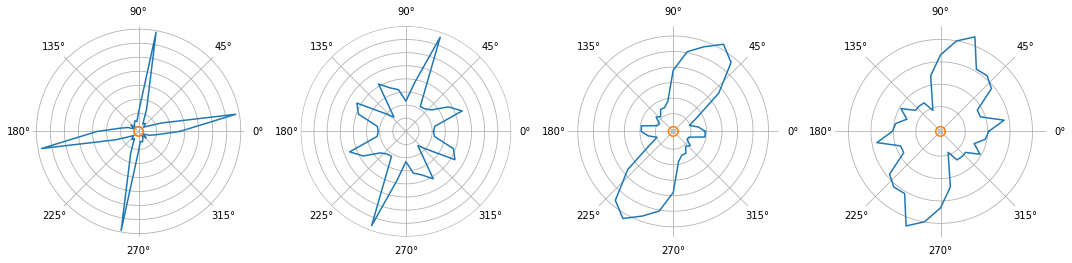

In [2]:
# SPATIAL PLOTS

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

layer = 'retina_relu2'
data = gratingsExperiment(model, layer)
responses = data['grating_responses']

ncells = n_bn if layer == 'retina_relu2' else 32
nr = max(1, ncells//4)
nc = min(4, ncells)
fig, ax = plt.subplots(nrows=nr, ncols=nc, squeeze=False, subplot_kw=dict(projection='polar'), figsize=(15,4*max(1,ncells//4)))

fig.tight_layout()


for cell in range(ncells):
    response = responses[:, cell]

    val, idx = torch.max(response, dim=0)
    max_params = data['grating_params'][idx.item()]

    rdata = {}
    for i,  p in enumerate(data['grating_params']):
        if p['freq'] == max_params['freq']:
            th = p['theta'].item()
            if not th in rdata:
                rdata[th] = response[i].item()
            else:
                rdata[th] += response[i].item()

    angles = list(rdata.keys())
    resps = list(rdata.values())
    angles.append(angles[0])
    resps.append(resps[0])
    resps = [i/36 for i in resps]
    ax[cell//4,cell%4].plot(angles, resps)
    ur = [data['uniform_responses'][0][cell].item()] * len(angles)
    ax[cell//4,cell%4].plot(angles, ur)

    ax[cell//4,cell%4].set_yticklabels([])                  #turn off radial tick labels (yticks)
    ax[cell//4,cell%4].spines['polar'].set_visible(False)    #turn off the axis spine

plt.savefig("figures/spatial_responses.eps")

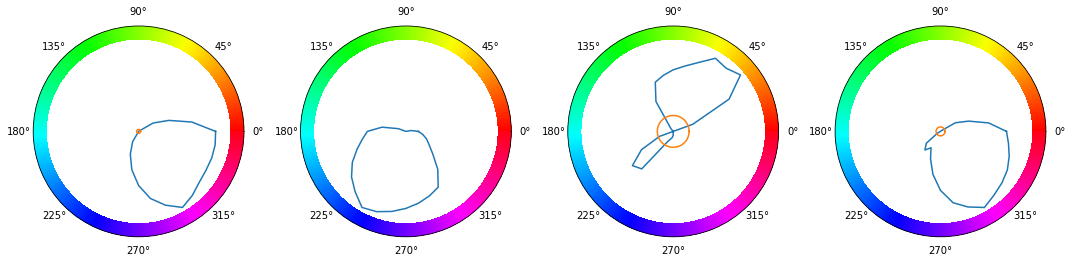

In [3]:
# SPECTRAL PLOTS
from statistics.devalois import deValoisExperiment
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import numpy.ma as ma

layer = 'retina_relu2'
data = deValoisExperiment(model, layer)
responses = data['hue_responses']

ncells = n_bn if layer == 'retina_relu2' else 32
nr = max(1,ncells//4)
nc = min(4, ncells)

fig, ax = plt.subplots(nrows=nr, ncols=nc, squeeze=False, subplot_kw=dict(projection='polar'), figsize=(15,4*max(1,ncells//4)))

fig.tight_layout()

norm = mpl.colors.Normalize(0, 2*np.pi) # Define colormap normalization for 0 to 2*pi
n = 2000  #the number of secants for the mesh
t = np.linspace(0,2*np.pi,n)   #theta values
r = np.linspace(.85,1,2)        #radius values change 0.6 to 0 for full circle
rg, tg = np.meshgrid(r,t)      #create a r,theta meshgrid
c = tg                         #define color values as theta value

data['hues'].append(data['hues'][0])

for cell in range(ncells):
    response = responses[:, cell].detach().cpu().numpy()
    response = np.append(response, response[0])
    hues = np.array(data['hues']) * np.pi / 180
    
    ax[cell//4,cell%4].plot(hues, response)
    ur = [data['uniform_responses'][0][cell].item()] * len(hues)

    ax[cell//4,cell%4].pcolormesh(t, (r+0.2)*np.max(response), c.T,norm=norm, cmap='hsv')  #plot the colormesh on axis with colormap
    
    ax[cell//4,cell%4].plot(hues, ur)

    ax[cell//4,cell%4].set_yticklabels([])                  #turn off radial tick labels (yticks)
    ax[cell//4,cell%4].spines['polar'].set_visible(True)    #turn off the axis spine

plt.savefig("figures/spectral_responses.eps")

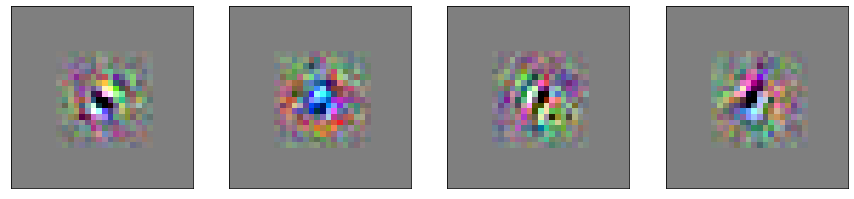

In [4]:
def deprocess_image(x):
    x -= x.mean()
    if (x.std() > 1e-5):
        x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    
    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


layer = 'retina_relu2'

ncells = n_bn if layer == 'retina_relu2' else 32
nr = max(1,ncells//4)
nc = min(4, ncells)

fig, ax = plt.subplots(nrows=nr, ncols=nc, squeeze=False, figsize=(15,4*max(1,ncells//4)))
for i in range(n_bn):
    input_img = torch.ones(1, n_ch, 32, 32, requires_grad=True, device='cpu')
    input_img.data = input_img.data * 0.01
    
    featuremaps = model.forward_to_layer(input_img, layer)
    loss = torch.mean(featuremaps[0,i,16,16]) #why the 16,16? because we pick the "centre" neuron...
    loss.backward()
    ax[i//4, i%4].imshow(deprocess_image(input_img.grad[0].detach().cpu().numpy()))
    ax[i//4,i%4].axes.get_xaxis().set_visible(False)
    ax[i//4,i%4].axes.get_yaxis().set_visible(False)
    
plt.savefig("figures/receptive_fields.eps")